In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

* torchvision.datasets - get datasets and data loading functions for computer vision
* torchvision.models - get pretrained computer models
* torchvision.transforms - functions for manipulating your vision data
* **torch.utils.data.Dataset** - Base dataset class for PyTorch
* **torch.utils.data.DataLoader** - Create a Python iterable over a dataset

# Getting a dataset 
- We will use fashionMNIST dataset

In [2]:
#Setup training data
train_data = datasets.FashionMNIST(root="data",#Where to download data to?
                                   train=True, #Do we want the training data?
                                   download=True,
                                   transform=ToTensor(),#How do we want to transform the data?
                                   target_transform=None#How do we want to transform the labels/targets?
                                  )
test_data = datasets.FashionMNIST(root="data",
                                   train=False, 
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
#Check the shape
image.shape, label, #Image shape is ["color channels, height, width"]

(torch.Size([1, 28, 28]), 9)

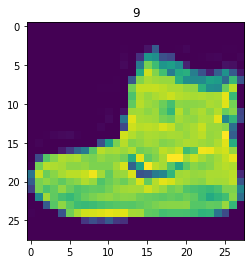

In [8]:
plt.imshow(image.squeeze())#Because plt needs height and width
plt.title(label);

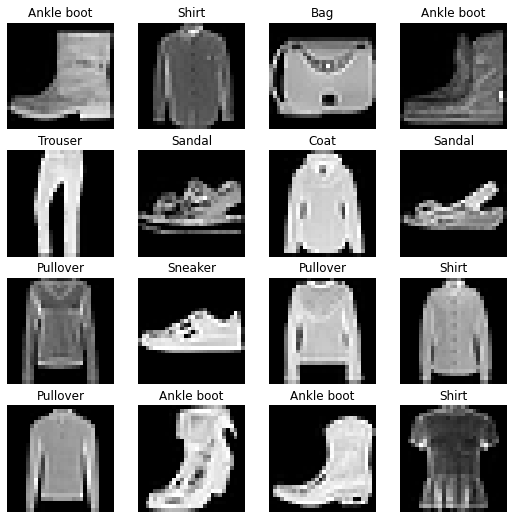

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()                          
    img , label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# Prepare DataLoader
* DataLoader turns our dataset into a Python iterable.
* More specifically, we want to turn our data into batcher(or misin-batches) 
1. It is more computationally efficient. Maybe, our harware is not able to look 60000 images in one hit. So we break down to 32 images at a time (batch size of 32).
2. It gives our neural network  more changes to update its gradients per epoch.

In [10]:
from torch.utils.data import DataLoader
# Setup the batch size hyperparameter
BATCH_SIZE = 32
#Turn  datasets into iterables(batches)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x270bac2a5e0>,
 <torch.utils.data.dataloader.DataLoader at 0x270bac2a5b0>)

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape

torch.Size([32, 1, 28, 28])

# Build a baseline model

In [12]:
# Start simply and add complexity when necessary
flatten_model = nn.Flatten()
# Get a single 
x = train_features_batch[0]
x.shape

torch.Size([1, 28, 28])

In [13]:
# Flatten the sample
output = flatten_model(x) # Perform forward pass
# Print out what happened
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [14]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                         nn.Linear(in_features=input_shape, out_features= hidden_units),
                                         nn.Linear(in_features=hidden_units, out_features= output_shape))
    def forward(self, x):
        return self.layer_stack(x)
        

In [15]:
torch.manual_seed(42)

#Setup model with input parameter
model_0 = FashionMNISTModelV0(input_shape=784,hidden_units=10,output_shape=len(class_names)).to("cpu")
model_0


FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [17]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Creating a function to time our experiements 

Two of the main things you will often want to track are:
1. Model's Performance 
2. How fast it runs

In [18]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Creating a training loop and training model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss **per batch**.
3. Loop through testing batches, perform testing steps, calculate the test loss **per batch**

In [19]:
from tqdm.auto import tqdm

In [20]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# Create training and test loop

for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n-----")
    ###Training
    train_loss = 0
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):#X is image, y is label
        model_0.train()
        
        # 1.Forward pass
        y_pred = model_0(X)
        
        # 2.Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss +=loss #
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)/len(train_dataloader.dataset)} samples.")
    # Divide total train loss by length of train dataloader
    train_loss /=len(test_dataloader) #Average loss per epoch
    
    ###Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1.Forward pass
            test_pred = model_0(X_test)
            
            # 2. Calculate the loss and accuracy
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        
        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)
            
        # Calculate the test accuracy average per batch 
        test_acc /=len(test_dataloader)
    
    print(f"\nTrain loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f} ")
# Calculate training time
train_time_end_on_cpu = timer()
total_time_model0 = print_train_time(start=train_time_start_on_cpu,end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0
-----
Looked at 0.0 samples.
Looked at 0.21333333333333335 samples.
Looked at 0.4266666666666667 samples.
Looked at 0.64 samples.
Looked at 0.8533333333333334 samples.

Train loss: 3.5367, Test loss: 0.5095, Test acc: 82.0387 
Epoch:1
-----
Looked at 0.0 samples.
Looked at 0.21333333333333335 samples.
Looked at 0.4266666666666667 samples.
Looked at 0.64 samples.
Looked at 0.8533333333333334 samples.

Train loss: 2.8534, Test loss: 0.4799, Test acc: 83.1969 
Epoch:2
-----
Looked at 0.0 samples.
Looked at 0.21333333333333335 samples.
Looked at 0.4266666666666667 samples.
Looked at 0.64 samples.
Looked at 0.8533333333333334 samples.

Train loss: 2.7258, Test loss: 0.4766, Test acc: 83.4265 
Train time on cpu: 28.346 seconds


# Make predictions and get Model 0 results

In [21]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device:torch.device):
    """Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data_loader)

        acc /=len(data_loader)
    return {"model_name":model.__class__.__name__, "model_loss":loss.item(), "model_acc": acc}

In [22]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,loss_fn= loss_fn, accuracy_fn=accuracy_fn, device="cpu")
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4766390025615692,
 'model_acc': 83.42651757188499}

In [23]:
# Setup device for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model 1: Building a better model with non-linearity

In [24]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into a single vector
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
        

In [25]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape= len(class_names)).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [26]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [27]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# Functionizing Training and Testing Loops

In [28]:
def train_step(model: nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn, 
               device: torch.device = device):
    ###Training
    train_loss, train_acc = 0, 0
    model.train()
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):#X is image, y is label
        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1.Forward pass
        y_pred = model(X)
        
        # 2.Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss +=loss #
        train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1)) # go from logits -> prediction labels
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    train_loss /=len(data_loader)
    train_acc /=len(data_loader)
    print(f"Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")
    
def test_step(model: nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               accuracy_fn, 
               device: torch.device = device
             ):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            # 1.Forward pass
            test_pred = model(X_test)
            
            # 2. Calculate the loss and accuracy
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        
        # Calculate the test loss average per batch
        test_loss /= len(data_loader)
            
        # Calculate the test accuracy average per batch 
        test_acc /=len(data_loader)
    
    print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

In [29]:
torch.manual_seed(42)

train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a loop using train_step and test_step
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model=model_1, 
               data_loader= train_dataloader, 
               loss_fn= loss_fn, 
               optimizer= optimizer, 
               accuracy_fn=accuracy_fn, 
               device=device)
    test_step(model=model_1,
              data_loader=test_dataloader, 
              loss_fn= loss_fn, 
              accuracy_fn= accuracy_fn, 
              device= device)

train_time_end_on_gpu = timer()

print_train_time(start=train_time_start_on_gpu, end= train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 1.09199, Train acc: 61.34%

Test loss: 0.9564, Test acc: 65.00%
Epoch: 1
-----
Train loss: 0.78101, Train acc: 71.93%

Test loss: 0.7223, Test acc: 73.91%
Epoch: 2
-----
Train loss: 0.67027, Train acc: 75.94%

Test loss: 0.6850, Test acc: 75.02%
Train time on cuda: 36.621 seconds


36.621013600000005

In [30]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

# New Part: Building a Convolutional Neural Network

In [31]:
#Create a CNN
class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG"""
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.Conv_Block1 = nn.Sequential(
            #We work with 2 dimensional data height and width
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size= 3, stride= 1, padding= 1), # Values we can set ourselves
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3 , stride=1 , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)  
        )
        self.Conv_Block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape) # There is a trick to calculating this
        )
    
    def forward(self, x):
        x = self.Conv_Block1(x)
        #print(f"Output shape of conv_1: {x.shape}")
        x = self.Conv_Block2(x)
        #print(f"Output shape of conv_2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape classifier: {x.shape}")
        return x
        

In [32]:
image.shape # input shape is number of channels

torch.Size([1, 28, 28])

In [33]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
im = image
im = im.to(device)
model_2(im.unsqueeze(0)).to(device)

tensor([[ 0.0135, -0.0230,  0.0398,  0.0066, -0.0652, -0.0029,  0.0536, -0.0665,
          0.0481, -0.0347]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [34]:
#Create a random test batch
torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")


Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])


In [35]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,3), stride=1, padding=0)
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

In [36]:
# Setup a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_model_2 = timer()

epochs = 3
# Train and test model
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_2,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
train_time_end_model_2 = timer()

print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.52523, Train acc: 81.06%

Test loss: 0.3819, Test acc: 86.36%
Epoch: 1
-------
Train loss: 0.34598, Train acc: 87.61%

Test loss: 0.3323, Test acc: 88.11%
Epoch: 2
-------
Train loss: 0.30926, Train acc: 88.92%

Test loss: 0.3130, Test acc: 88.80%
Train time on cuda: 39.211 seconds


39.210926900000004

In [38]:
model_2_results = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn,device=device)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31300267577171326,
 'model_acc': 88.7979233226837}

In [39]:
model_3 = FashionMNISTModelV2(input_shape=1, hidden_units= 30, output_shape= len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

train_time_start_model_3 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    
    train_step(model=model_3,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_3,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
train_time_end_model_3 = timer()

print_train_time(start=train_time_start_model_3, end=train_time_end_model_3, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.51096, Train acc: 81.57%

Test loss: 0.3449, Test acc: 87.42%
Epoch: 1
-------
Train loss: 0.29325, Train acc: 89.59%

Test loss: 0.2942, Test acc: 89.44%
Epoch: 2
-------
Train loss: 0.25677, Train acc: 90.79%

Test loss: 0.2852, Test acc: 89.86%
Train time on cuda: 41.523 seconds


41.522742100000016

# Make and Evaluare random predictions with best model

In [40]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim = 0)

            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

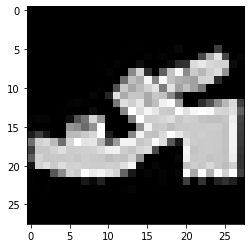

In [41]:
import random 
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

plt.imshow(test_samples[0].squeeze(), cmap="gray")

In [42]:
pred_probs = make_predictions(model=model_2, data=test_samples, device=device)
# Convert prediction probabilities to labels
pred_class = pred_probs.argmax(dim=1)
pred_class


tensor([5, 3, 7, 4, 3, 0, 4, 7, 1])

# Save and Load best performing model

In [43]:
from pathlib import Path

In [44]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok= True)

MODEL_NAME = "FashionMNISTModel"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_3.state_dict(),f=MODEL_SAVE_PATH)